## PREDICCION DE LA CURVA DE CONTAGIOS COVID19 en el Peru para el año 2021
### Usando datos del MINSA del periodo 2020-03-06 al 2021-02-06

* Los datos del ministerio de salud se disponen de una recopilacion de casos positivos diarios
* Fuente: https://www.datosabiertos.gob.pe/dataset/casos-positivos-por-covid-19-ministerio-de-salud-minsa

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

In [2]:
np.random.seed(42) ##para que los resultados sean reproducibles

### OBTENCION DE DATOS

In [3]:
data=pd.read_csv(r"C:\Users\JOHAN\Downloads\positivos_covid.csv",sep=";")

In [4]:
data.head()

,FECHA_CORTE,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO
0,20210206,7320cabdc1aaca6c59014cae76a134e6,LIMA,LIMA,LINCE,PR,12.0,FEMENINO,20200922.0
1,20210206,027561e9d126e7c283d79c02cede562d,LIMA,LIMA,BREÑA,PR,12.0,FEMENINO,20200923.0
2,20210206,f016889b9ba5bd95cf15d60205cbd82e,LIMA,LIMA,CHORRILLOS,PR,12.0,FEMENINO,20200923.0
3,20210206,971f8e1295583756d81fe42f3318488c,LIMA,LIMA,PUEBLO LIBRE,PR,12.0,FEMENINO,20200923.0
4,20210206,bc45b71b005a96f32eeb97060616a999,LIMA,LIMA,VILLA EL SALVADOR,PR,12.0,FEMENINO,20200923.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   FECHA_CORTE      1048575 non-null  int64  
 1   UUID             1048575 non-null  object 
 2   DEPARTAMENTO     1048575 non-null  object 
 3   PROVINCIA        1048575 non-null  object 
 4   DISTRITO         1048575 non-null  object 
 5   METODODX         1048575 non-null  object 
 6   EDAD             1048317 non-null  float64
 7   SEXO             1048575 non-null  object 
 8   FECHA_RESULTADO  1046647 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


### Exploracion y preparacion de datos

In [6]:
data=data.dropna(axis="index",how="any",subset=["FECHA_RESULTADO","FECHA_CORTE"]) #eliminamos algunos valores nulos (puede afectar la precision)

In [7]:
data["FECHA_RESULTADO"].isnull().sum()

0

In [8]:
data["FECHA_RESULTADO"]=data["FECHA_RESULTADO"].astype("int64")
data["FECHA_RESULTADO"]=data["FECHA_RESULTADO"].astype("str")
data["FECHA_CORTE"]=data["FECHA_CORTE"].astype("str")

In [9]:
data["FECHA_CORTE"]=pd.to_datetime(data["FECHA_CORTE"],format="%Y-%m-%d")
data["FECHA_RESULTADO"]=pd.to_datetime(data["FECHA_RESULTADO"],format="%Y-%m-%d")

In [10]:
data.head()

,FECHA_CORTE,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO
0,2021-02-06,7320cabdc1aaca6c59014cae76a134e6,LIMA,LIMA,LINCE,PR,12.0,FEMENINO,2020-09-22
1,2021-02-06,027561e9d126e7c283d79c02cede562d,LIMA,LIMA,BREÑA,PR,12.0,FEMENINO,2020-09-23
2,2021-02-06,f016889b9ba5bd95cf15d60205cbd82e,LIMA,LIMA,CHORRILLOS,PR,12.0,FEMENINO,2020-09-23
3,2021-02-06,971f8e1295583756d81fe42f3318488c,LIMA,LIMA,PUEBLO LIBRE,PR,12.0,FEMENINO,2020-09-23
4,2021-02-06,bc45b71b005a96f32eeb97060616a999,LIMA,LIMA,VILLA EL SALVADOR,PR,12.0,FEMENINO,2020-09-23


In [11]:
infected=data.groupby(["FECHA_RESULTADO"]).aggregate(INFECTADOS=pd.NamedAgg(column="FECHA_RESULTADO",aggfunc="count"))

In [12]:
infected.head()

,INFECTADOS
FECHA_RESULTADO,
2020-03-06,1
2020-03-07,5
2020-03-08,2
2020-03-09,2
2020-03-10,1


In [13]:
infected.sort_index(inplace=True)

In [14]:
infected.head()

,INFECTADOS
FECHA_RESULTADO,
2020-03-06,1
2020-03-07,5
2020-03-08,2
2020-03-09,2
2020-03-10,1


<AxesSubplot:xlabel='FECHA_RESULTADO'>

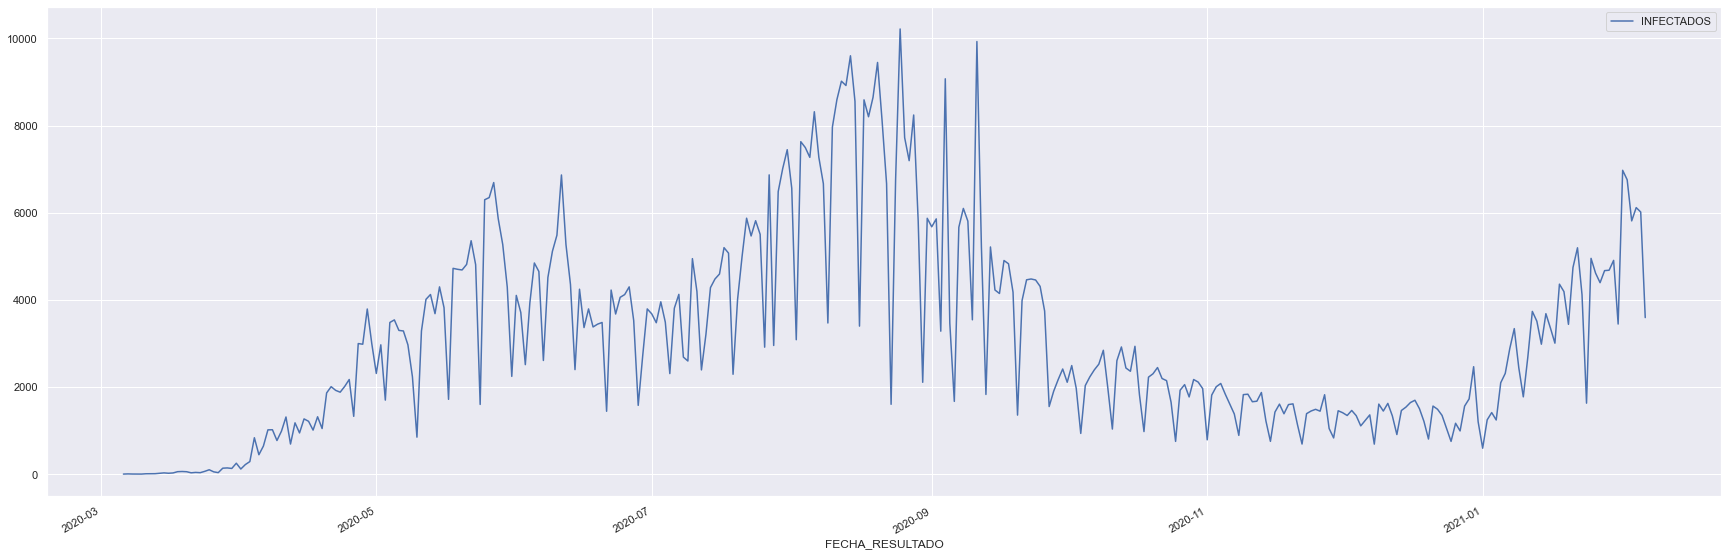

In [15]:
infected.plot(figsize=(30,10)) #mostramos la curva real de infectados 

In [16]:
def create_series(data,n_past=1,n_future=1):
    X,y=[],[]
    for i in range(n_past,len(data)-n_future+1):
        X.append(data[i-n_past:i,[0]])
        y.append(data[i+n_future-1:i+n_future,0])
    return np.array(X),np.array(y)

In [17]:
#separacion de datos
index=round(len(infected)*0.7)

In [18]:
train=infected[:index]
test=infected[index:]

In [19]:
#escalamiento de datos
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))

train_scaled=scaler.fit_transform(train)
test_scaled= scaler.transform(test)

In [20]:
#remodelamiento de datos
n_past=30   #usare 30 dias anteriores para predecir el futuro
n_future=1  #predicire un dia en el futuro
x_train,y_train=create_series(train_scaled,n_past,n_future)
x_test,y_test=create_series(test_scaled,n_past,n_future)

In [21]:
#verificamos el remodelamiento
x_train.shape,y_train.shape

((205, 30, 1), (205, 1))

## SELECCION DEL MODELO
* Contruccion de arquitectura de red
* Busqueda de hiperparametros

In [22]:
import tensorflow as tf
from keras.utils import plot_model


In [23]:
n_steps=30 # pasos de tiempo usados
n_features=1 #caracterisiticas (solo una columna)
def build_model():
    model=tf.keras.models.Sequential(name="SEQUENTIAL_MODEL")
    model.add(tf.keras.Input(shape=(n_steps,n_features),name="INPUT"))
    model.add(tf.keras.layers.LSTM(units=64,return_sequences=True,name="LSTMx64"))
    model.add(tf.keras.layers.Dropout(0.2,name="DROPOUT_1"))
    model.add(tf.keras.layers.LSTM(units=32,return_sequences=False,name="LSTMx32"))
    model.add(tf.keras.layers.Dropout(0.2,name="DROPOUT_2"))
    model.add(tf.keras.layers.Dense(1,name="OUTPUT"))
    #compilacion del modelo
    model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
    return model

In [24]:
model_lstm=build_model()

In [25]:
model_lstm.summary()

Model: "SEQUENTIAL_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTMx64 (LSTM)               (None, 30, 64)            16896     
_________________________________________________________________
DROPOUT_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
LSTMx32 (LSTM)               (None, 32)                12416     
_________________________________________________________________
DROPOUT_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
OUTPUT (Dense)               (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


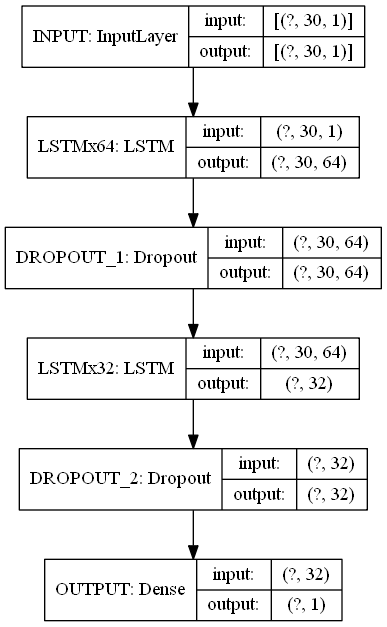

In [26]:
plot_model(model_lstm,show_shapes=True)

In [27]:
#entrenamiento del modelo
model_lstm=build_model()
history=model_lstm.fit(x_train,y_train,epochs=100,batch_size=32,validation_split=0.2)

Epoch 1/100
6/6 [==============================] - 2s 310ms/step - loss: 0.0999 - mae: 0.2350 - val_loss: 0.0073 - val_mae: 0.0710
Epoch 2/100
6/6 [==============================] - 0s 44ms/step - loss: 0.0346 - mae: 0.1432 - val_loss: 0.0120 - val_mae: 0.0823
Epoch 3/100
6/6 [==============================] - 0s 49ms/step - loss: 0.0296 - mae: 0.1272 - val_loss: 0.0366 - val_mae: 0.1703
Epoch 4/100
6/6 [==============================] - 0s 56ms/step - loss: 0.0404 - mae: 0.1564 - val_loss: 0.0213 - val_mae: 0.1189
Epoch 5/100
6/6 [==============================] - 0s 49ms/step - loss: 0.0356 - mae: 0.1407 - val_loss: 0.0416 - val_mae: 0.1845
Epoch 6/100
6/6 [==============================] - 0s 47ms/step - loss: 0.0266 - mae: 0.1286 - val_loss: 0.0661 - val_mae: 0.2405
Epoch 7/100
6/6 [==============================] - 0s 51ms/step - loss: 0.0315 - mae: 0.1342 - val_loss: 0.0299 - val_mae: 0.1504
Epoch 8/100
6/6 [==============================] - 0s 49ms/step - loss: 0.0293 - mae: 0.1

6/6 [==============================] - 0s 39ms/step - loss: 0.0256 - mae: 0.1166 - val_loss: 0.0160 - val_mae: 0.0968
Epoch 64/100
6/6 [==============================] - 0s 38ms/step - loss: 0.0259 - mae: 0.1137 - val_loss: 0.0073 - val_mae: 0.0641
Epoch 65/100
6/6 [==============================] - 0s 48ms/step - loss: 0.0251 - mae: 0.1170 - val_loss: 0.0172 - val_mae: 0.1017
Epoch 66/100
6/6 [==============================] - 0s 50ms/step - loss: 0.0250 - mae: 0.1175 - val_loss: 0.0070 - val_mae: 0.0653
Epoch 67/100
6/6 [==============================] - 0s 47ms/step - loss: 0.0252 - mae: 0.1163 - val_loss: 0.0113 - val_mae: 0.0773
Epoch 68/100
6/6 [==============================] - 0s 57ms/step - loss: 0.0246 - mae: 0.1114 - val_loss: 0.0083 - val_mae: 0.0682
Epoch 69/100
6/6 [==============================] - 0s 47ms/step - loss: 0.0243 - mae: 0.1143 - val_loss: 0.0156 - val_mae: 0.0956
Epoch 70/100
6/6 [==============================] - 0s 41ms/step - loss: 0.0277 - mae: 0.1140 - 

In [28]:

def plot_loss(history):
    epochs=range(1,len(history["loss"])+1)
    plt.plot(epochs,history["loss"],"bo-",label=" loss train")
    plt.plot(epochs,history["val_loss"],"ro-",label=" loss test")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(loc="best")
    plt.show()
    
def plot_metrics(history):
    epochs=range(1,len(history["mae"])+1)
    plt.plot(epochs,history["mae"],"bo-",label=" MAE train")
    plt.plot(epochs,history["val_mae"],"ro-",label=" MAE test")
    plt.xlabel("epochs")
    plt.ylabel("MAE: Error absoluto Medio")
    plt.legend(loc="best")
    plt.show()


## Evaluacion del modelo v1.0
* Se busca comparar los resulados de rendimiento del modelo en datos de train y test en la primera configuracion 
* En funcion a esta primera linea base se toman decisiones de mejorar el modelo en casos de sobreajuste y subajuste

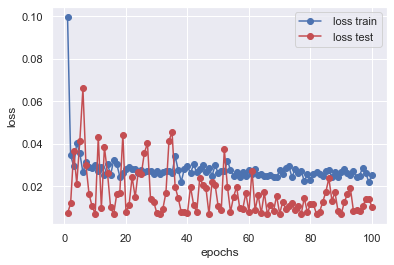

In [29]:
plot_loss(history.history)

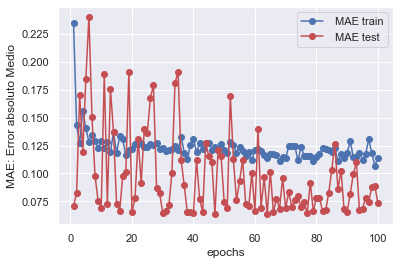

In [30]:
plot_metrics(history.history)

In [40]:
#reestructuracion del modelo
n_steps=30 # pasos de tiempo usados
n_features=1 #caracterisiticas (solo una columna)
def build_model():
    model=tf.keras.models.Sequential(name="SEQUENTIAL_MODEL")
    model.add(tf.keras.Input(shape=(n_steps,n_features),name="INPUT"))
    model.add(tf.keras.layers.LSTM(units=128,return_sequences=False,name="LSTMx128"))
    model.add(tf.keras.layers.Dropout(0.2,name="DROPOUT_1"))
    #model.add(tf.keras.layers.LSTM(units=32,return_sequences=False,name="LSTMx32"))
    #model.add(tf.keras.layers.Dropout(0.2,name="DROPOUT_2"))
    model.add(tf.keras.layers.Dense(1,name="OUTPUT"))
    #compilacion del modelo
    model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
    return model

In [49]:
#entrenamiento del modelo
model_lstm=build_model()
history=model_lstm.fit(x_train,y_train,epochs=200,batch_size=1,validation_split=0.2)

Epoch 1/200
164/164 [==============================] - 2s 14ms/step - loss: 0.0360 - mae: 0.1378 - val_loss: 0.0083 - val_mae: 0.0643
Epoch 2/200
164/164 [==============================] - 2s 10ms/step - loss: 0.0310 - mae: 0.1227 - val_loss: 0.0068 - val_mae: 0.0621
Epoch 3/200
164/164 [==============================] - 2s 10ms/step - loss: 0.0293 - mae: 0.1246 - val_loss: 0.0191 - val_mae: 0.1104
Epoch 4/200
164/164 [==============================] - 2s 10ms/step - loss: 0.0292 - mae: 0.1251 - val_loss: 0.0125 - val_mae: 0.0816
Epoch 5/200
164/164 [==============================] - 2s 10ms/step - loss: 0.0288 - mae: 0.1286 - val_loss: 0.0074 - val_mae: 0.0618
Epoch 6/200
164/164 [==============================] - 2s 11ms/step - loss: 0.0279 - mae: 0.1245 - val_loss: 0.0066 - val_mae: 0.0633
Epoch 7/200
164/164 [==============================] - 2s 11ms/step - loss: 0.0267 - mae: 0.1217 - val_loss: 0.0136 - val_mae: 0.0859
Epoch 8/200
164/164 [==============================] - 2s 10ms

Epoch 62/200
164/164 [==============================] - 2s 13ms/step - loss: 0.0143 - mae: 0.0846 - val_loss: 0.0070 - val_mae: 0.0696
Epoch 63/200
164/164 [==============================] - 2s 13ms/step - loss: 0.0155 - mae: 0.0883 - val_loss: 0.0061 - val_mae: 0.0626
Epoch 64/200
164/164 [==============================] - 2s 12ms/step - loss: 0.0152 - mae: 0.0886 - val_loss: 0.0042 - val_mae: 0.0546
Epoch 65/200
164/164 [==============================] - 2s 12ms/step - loss: 0.0145 - mae: 0.0883 - val_loss: 0.0026 - val_mae: 0.0387
Epoch 66/200
164/164 [==============================] - 2s 11ms/step - loss: 0.0146 - mae: 0.0856 - val_loss: 0.0035 - val_mae: 0.0467
Epoch 67/200
164/164 [==============================] - 2s 12ms/step - loss: 0.0177 - mae: 0.0943 - val_loss: 0.0093 - val_mae: 0.0809
Epoch 68/200
164/164 [==============================] - 2s 12ms/step - loss: 0.0141 - mae: 0.0878 - val_loss: 0.0065 - val_mae: 0.0695
Epoch 69/200
164/164 [==============================] -

164/164 [==============================] - 2s 12ms/step - loss: 0.0098 - mae: 0.0668 - val_loss: 0.0060 - val_mae: 0.0596
Epoch 123/200
164/164 [==============================] - 2s 11ms/step - loss: 0.0107 - mae: 0.0693 - val_loss: 0.0073 - val_mae: 0.0732
Epoch 124/200
164/164 [==============================] - 2s 12ms/step - loss: 0.0116 - mae: 0.0714 - val_loss: 0.0124 - val_mae: 0.0887
Epoch 125/200
164/164 [==============================] - 2s 11ms/step - loss: 0.0109 - mae: 0.0744 - val_loss: 0.0111 - val_mae: 0.0850
Epoch 126/200
164/164 [==============================] - 2s 11ms/step - loss: 0.0103 - mae: 0.0707 - val_loss: 0.0041 - val_mae: 0.0485
Epoch 127/200
164/164 [==============================] - 2s 11ms/step - loss: 0.0096 - mae: 0.0682 - val_loss: 0.0067 - val_mae: 0.0692
Epoch 128/200
164/164 [==============================] - 2s 11ms/step - loss: 0.0122 - mae: 0.0752 - val_loss: 0.0065 - val_mae: 0.0679
Epoch 129/200
164/164 [==============================] - 2s 11

164/164 [==============================] - 2s 11ms/step - loss: 0.0073 - mae: 0.0597 - val_loss: 0.0048 - val_mae: 0.0521
Epoch 183/200
164/164 [==============================] - 2s 11ms/step - loss: 0.0075 - mae: 0.0623 - val_loss: 0.0067 - val_mae: 0.0676
Epoch 184/200
164/164 [==============================] - 2s 12ms/step - loss: 0.0065 - mae: 0.0579 - val_loss: 0.0062 - val_mae: 0.0687
Epoch 185/200
164/164 [==============================] - 2s 11ms/step - loss: 0.0080 - mae: 0.0630 - val_loss: 0.0059 - val_mae: 0.0622
Epoch 186/200
164/164 [==============================] - 2s 12ms/step - loss: 0.0075 - mae: 0.0632 - val_loss: 0.0081 - val_mae: 0.0746
Epoch 187/200
164/164 [==============================] - 2s 12ms/step - loss: 0.0071 - mae: 0.0616 - val_loss: 0.0053 - val_mae: 0.0625
Epoch 188/200
164/164 [==============================] - 2s 11ms/step - loss: 0.0079 - mae: 0.0617 - val_loss: 0.0062 - val_mae: 0.0632
Epoch 189/200
164/164 [==============================] - 2s 12

### EVALUACION DEL MODELO v2.0

* Verificacion de resultados luego de una serie de ajuste de hiperparametros para mejorar el rendimiento

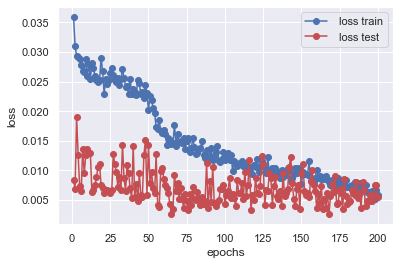

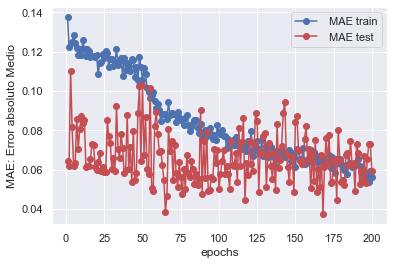

In [50]:
plot_loss(history.history)
plot_metrics(history.history)

In [51]:
#rendimiento en los datos de prueba
model_lstm.evaluate(x_test,y_test)

3/3 [==============================] - 0s 7ms/step - loss: 0.0068 - mae: 0.0609


[0.006799119990319014, 0.060920123010873795]

In [56]:
model_lstm.evaluate(x_train,y_train)

7/7 [==============================] - 0s 14ms/step - loss: 0.0068 - mae: 0.0577


[0.00677406694740057, 0.05769547075033188]

In [57]:
y_pred_test=model_lstm.predict(x_test)
y_pred_train=model_lstm.predict(x_train)

In [81]:
result_test=pd.DataFrame({
    "Y true":scaler.inverse_transform(y_test).flatten(),
    "Y pred":scaler.inverse_transform(y_pred_test).flatten()
},index=test.index[n_past+n_future-1:])
result_train=pd.DataFrame({
    "Y true":scaler.inverse_transform(y_train).flatten(),
    "Y pred":scaler.inverse_transform(y_pred_train).flatten()
},index=train.index[n_past+n_future-1:])

In [82]:
result_test.head()

,Y true,Y pred
FECHA_RESULTADO,,
2020-11-27,1822.0,2171.096680
2020-11-28,1046.0,1989.981567
2020-11-29,830.0,1597.217163
2020-11-30,1454.0,1342.009277
2020-12-01,1409.0,1545.845093


<AxesSubplot:xlabel='FECHA_RESULTADO'>

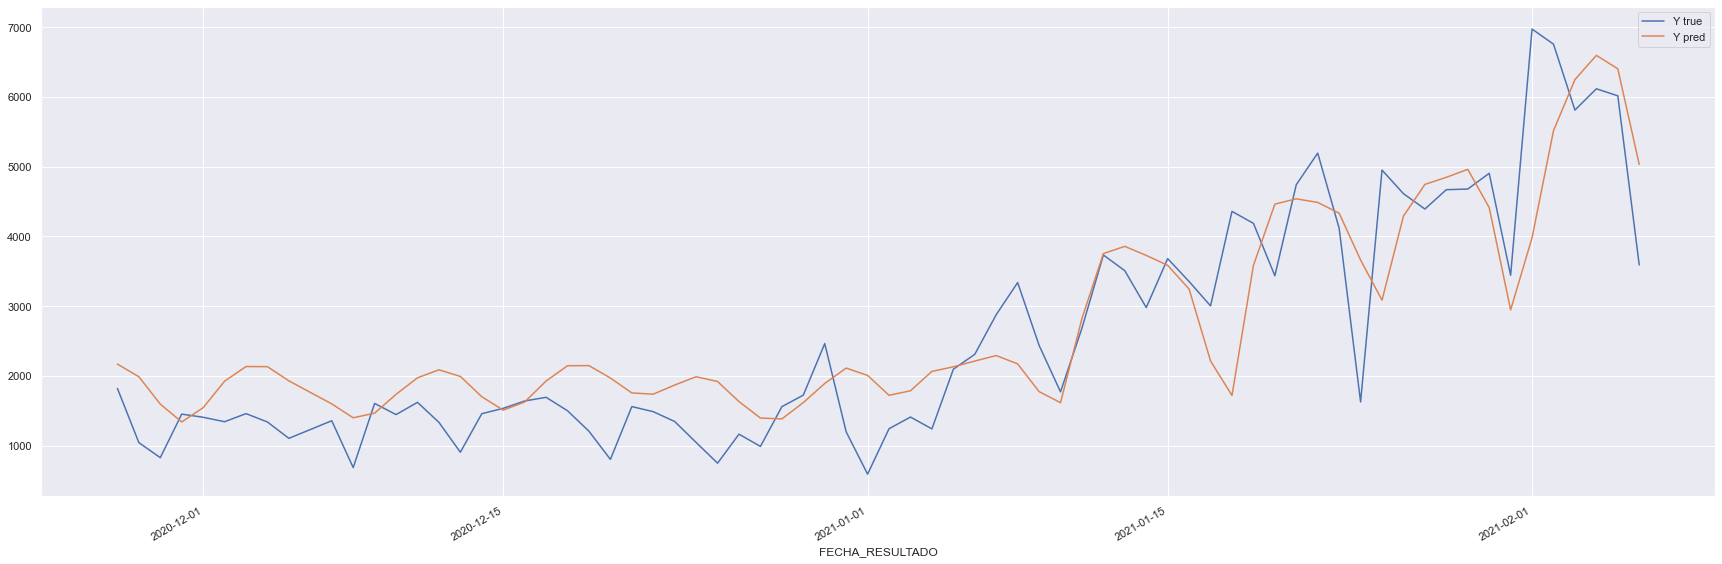

In [83]:
#grafica de los datos de testeo
result_test.plot(figsize=(30,10))

In [84]:
#grafica de los datos de entrenamiento
result_train.head()

,Y true,Y pred
FECHA_RESULTADO,,
2020-04-05,445.0,807.403442
2020-04-06,644.0,925.343262
2020-04-07,1016.0,997.348694
2020-04-08,1018.0,1030.098022
2020-04-09,771.0,1106.643799


* COMPARACION ENTRE LA DATA REAL Y LA DATA ESTIMADA en los datos de entrenamiento

<AxesSubplot:xlabel='FECHA_RESULTADO'>

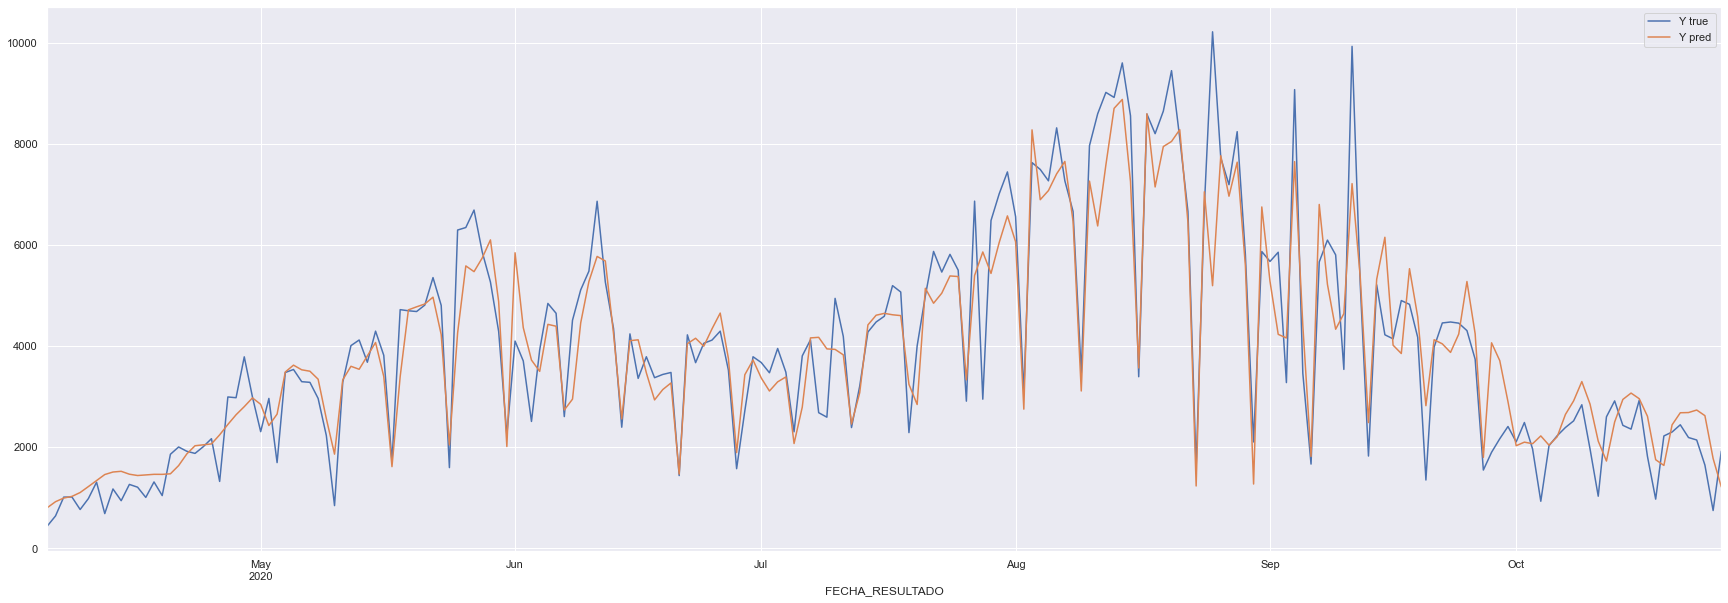

In [85]:
result_train.plot(figsize=(30,10))

In [87]:
#como el modelo esta en prefecto estado (un poco de equilibrio en los resultados)
#entrenamos los datos en todo el set de datos
from sklearn.preprocessing import MinMaxScaler
scaler_t=MinMaxScaler(feature_range=(0,1))
total_data=infected.values
total_scaled=scaler_t.fit_transform(total_data)


In [91]:
n_past=30 #se usaran 30 dias anteriores para predecir el futuro
n_future=1 #dias a predecir en el futuro
X_total,y_total=create_series(total_scaled,n_past,n_future)

In [92]:
#entrenamiento del modelo
model_lstm=build_model()
history=model_lstm.fit(X_total,y_total,epochs=200,batch_size=1,validation_split=0.2)

Epoch 1/200
244/244 [==============================] - 4s 15ms/step - loss: 0.0283 - mae: 0.1195 - val_loss: 0.0088 - val_mae: 0.0701
Epoch 2/200
244/244 [==============================] - 3s 12ms/step - loss: 0.0196 - mae: 0.1022 - val_loss: 0.0066 - val_mae: 0.0537
Epoch 3/200
244/244 [==============================] - 3s 12ms/step - loss: 0.0222 - mae: 0.1020 - val_loss: 0.0084 - val_mae: 0.0677
Epoch 4/200
244/244 [==============================] - 3s 13ms/step - loss: 0.0217 - mae: 0.1048 - val_loss: 0.0070 - val_mae: 0.0603
Epoch 5/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0219 - mae: 0.1011 - val_loss: 0.0063 - val_mae: 0.0537
Epoch 6/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0219 - mae: 0.1022 - val_loss: 0.0133 - val_mae: 0.0908
Epoch 7/200
244/244 [==============================] - 3s 12ms/step - loss: 0.0212 - mae: 0.1018 - val_loss: 0.0101 - val_mae: 0.0772
Epoch 8/200
244/244 [==============================] - 3s 12ms

Epoch 62/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0108 - mae: 0.0745 - val_loss: 0.0052 - val_mae: 0.0526
Epoch 63/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0123 - mae: 0.0739 - val_loss: 0.0049 - val_mae: 0.0516
Epoch 64/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0108 - mae: 0.0739 - val_loss: 0.0046 - val_mae: 0.0501
Epoch 65/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0108 - mae: 0.0699 - val_loss: 0.0062 - val_mae: 0.0593
Epoch 66/200
244/244 [==============================] - 3s 12ms/step - loss: 0.0103 - mae: 0.0711 - val_loss: 0.0051 - val_mae: 0.0516
Epoch 67/200
244/244 [==============================] - 3s 12ms/step - loss: 0.0111 - mae: 0.0705 - val_loss: 0.0068 - val_mae: 0.0616
Epoch 68/200
244/244 [==============================] - 3s 12ms/step - loss: 0.0117 - mae: 0.0725 - val_loss: 0.0077 - val_mae: 0.0658
Epoch 69/200
244/244 [==============================] -

244/244 [==============================] - 3s 12ms/step - loss: 0.0075 - mae: 0.0564 - val_loss: 0.0064 - val_mae: 0.0585
Epoch 123/200
244/244 [==============================] - 3s 12ms/step - loss: 0.0063 - mae: 0.0530 - val_loss: 0.0048 - val_mae: 0.0526
Epoch 124/200
244/244 [==============================] - 3s 12ms/step - loss: 0.0074 - mae: 0.0607 - val_loss: 0.0068 - val_mae: 0.0590
Epoch 125/200
244/244 [==============================] - 3s 12ms/step - loss: 0.0071 - mae: 0.0599 - val_loss: 0.0060 - val_mae: 0.0588
Epoch 126/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0077 - mae: 0.0577 - val_loss: 0.0044 - val_mae: 0.0493
Epoch 127/200
244/244 [==============================] - 3s 12ms/step - loss: 0.0070 - mae: 0.0557 - val_loss: 0.0061 - val_mae: 0.0577
Epoch 128/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0097 - mae: 0.0576 - val_loss: 0.0051 - val_mae: 0.0561
Epoch 129/200
244/244 [==============================] - 3s 11

244/244 [==============================] - 3s 11ms/step - loss: 0.0054 - mae: 0.0515 - val_loss: 0.0051 - val_mae: 0.0549
Epoch 183/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0058 - mae: 0.0499 - val_loss: 0.0062 - val_mae: 0.0584
Epoch 184/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0054 - mae: 0.0501 - val_loss: 0.0052 - val_mae: 0.0538
Epoch 185/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0046 - mae: 0.0465 - val_loss: 0.0052 - val_mae: 0.0556
Epoch 186/200
244/244 [==============================] - 3s 12ms/step - loss: 0.0054 - mae: 0.0482 - val_loss: 0.0050 - val_mae: 0.0539
Epoch 187/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0054 - mae: 0.0503 - val_loss: 0.0058 - val_mae: 0.0554
Epoch 188/200
244/244 [==============================] - 3s 11ms/step - loss: 0.0051 - mae: 0.0482 - val_loss: 0.0049 - val_mae: 0.0539
Epoch 189/200
244/244 [==============================] - 3s 11

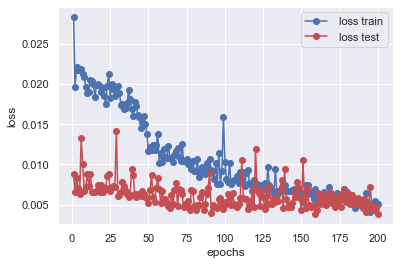

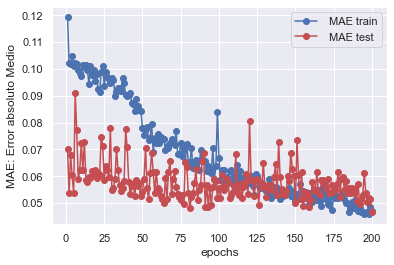

In [93]:
#mostramos los resultados totales del modelo
plot_loss(history.history)
plot_metrics(history.history)

In [94]:
model_lstm.evaluate(X_total,y_total)

10/10 [==============================] - 0s 16ms/step - loss: 0.0035 - mae: 0.0423


[0.003519657766446471, 0.04227583110332489]

In [100]:
y_pred=model_lstm.predict(X_total)

In [104]:
result_total=pd.DataFrame({
    "Y true":scaler_t.inverse_transform(y_total).flatten(),
    "Y pred":scaler_t.inverse_transform(y_pred).flatten()
},index=infected.index[n_past+n_future-1:])

In [105]:
result_total.head() #en mi opinion es muy visible el error absoluto

,Y true,Y pred
FECHA_RESULTADO,,
2020-04-05,445.0,872.274170
2020-04-06,644.0,877.211548
2020-04-07,1016.0,911.136841
2020-04-08,1018.0,1000.845337
2020-04-09,771.0,1075.136475


#### Grafica del los resultados entre los datos de infectaod verdadero y estimados reflejados en la curva de contagios

* Curva azul: Curva verdadera
* Curva roja: Curva estimada por el modelo de Deep Learning

<AxesSubplot:xlabel='FECHA_RESULTADO'>

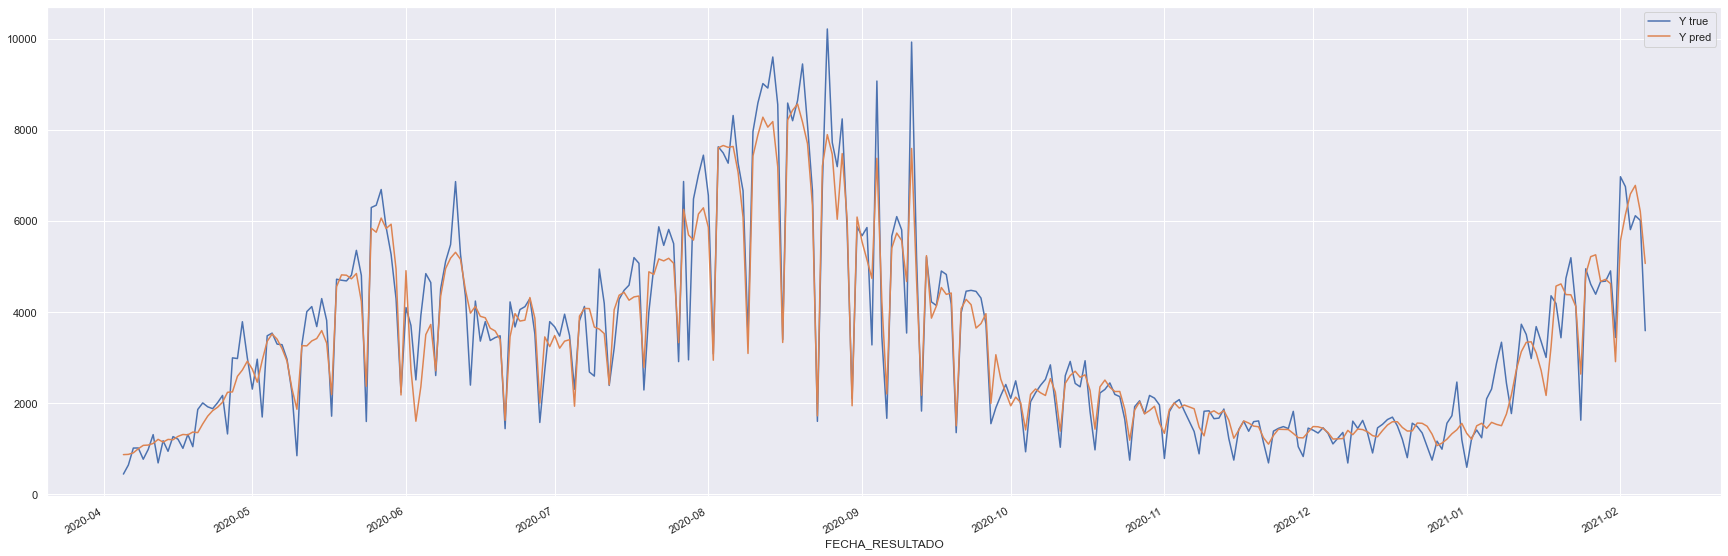

In [106]:
result_total.plot(figsize=(30,10))

In [107]:
model_lstm.save("lstm_predict_covid19")

INFO:tensorflow:Assets written to: lstm_predict_covid19\assets


In [108]:
#como el modelo tiene buenos resultados en el entrenamiento y prueba procedemos a cargarlo para hacer predicciones
from keras.models import load_model

In [109]:
model_lstm_loaded=load_model("lstm_predict_covid19")

## APLICACION: Curva de contagios para los proximos N dias
#### Usando datos desde inicio del COVID19 hasta el 06-02-2021

In [176]:
#alistamos el entorno de trabajo
#requisitos: la curva de contagios en los proximos 3 meses
n_dias=90 #para los proximos 90 dias, haremos 90 predicciones en escala

def model_generate_predict(model=None,data_start=None,n_futures=1):
    """
    model:Modelo para realizar la prediccion
    data_start: Las serie de tiempo inicial para iniciar la prediccion de forma (n_steps,features) -> (30,1)
    n_futures: Total de pasos de tiempo a predecir
    """
    n_samples=1 #se ingresa una muestra para la prediccion
    n_steps=30 #se usan 30 dias para la prediccion
    n_features=1 #solo se cuenta con una caracteristica que es el contagio diario
    prediccion=[] #lista de predicciones
    for i in range(n_futures):
        y=model.predict(data_start.reshape((n_samples,n_steps,n_features))) #obtendo el dato predecido
        data_start=data_start[1:] #elimino el primer valor
        data_start=np.concatenate([data_start,y],axis=0) #agrego el ultimo valor
        prediccion.append(y.flatten())
    return np.array(prediccion)

In [177]:
data_start=X_total[-1] #se iniciara la prediccion con la ultima muestra de los datos reales
N=90 #numero de dias predecir
y_prediccion=model_generate_predict(model_lstm_loaded,data_start,N)

In [166]:
#creamos el contexto
last_time=infected.index[-1] #escogemos la ultima fecha del set de datos del MINSA

In [167]:
index_range=pd.date_range(start=last_time,periods=N+1,freq="D",closed="right") #generamos N=90 datos diarios(freq)


In [187]:
results=pd.DataFrame({
    "INFECTADOS":scaler_t.inverse_transform(y_prediccion).flatten()
    },
    index=index_range
    )

In [188]:
results.head()

,INFECTADOS
2021-02-07,5068.560547
2021-02-08,6751.715332
2021-02-09,6379.598145
2021-02-10,6882.264160
2021-02-11,7692.468750


## CURVA DE CONTAGIOS PREDECIDA COVID19 con LSTM en Keras

### Grafica de prediccion independiente desde 2021-02-07 a 2021-05-07

<AxesSubplot:>

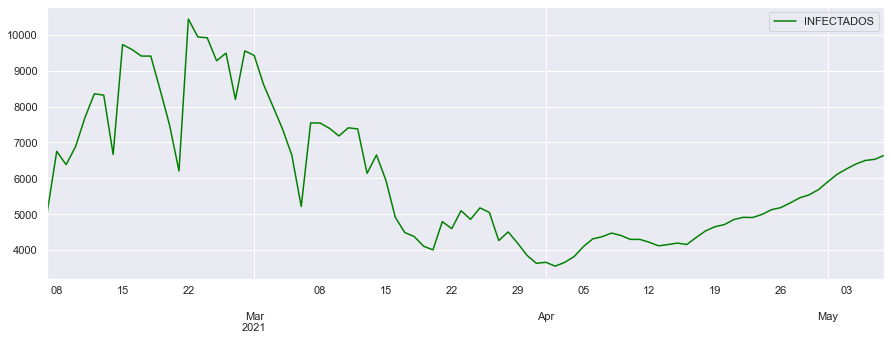

In [189]:
#grafica
results.plot(figsize=(15,5),color="green")

### Grafica de prediccion complementaria de infecciones COVID19  desde 2020-03-06 a 2021-05-07

In [197]:
def plot_prediccion_total(result_true,result_predict):
    plt.figure(figsize=(30,10))
    plt.plot(result_true["INFECTADOS"],color="blue",label="Infeccion Actual")
    plt.axvline(x=result_predict.index[0],color="green")
    plt.plot(result_predict["INFECTADOS"],color="red",label="Infeccion Estimada")
    plt.xlabel("Linea de tiempo")
    plt.ylabel("Numero de infectados")
    plt.legend(loc="best")
    plt.show()

### Grafica de comparacion entre la curva de infecciones hasta la fecha y la predecida para el futuro
* Grafica azul: Curva de infecciones hasta la fecha 2021-02-06
* Grafica roja: Cruva predecida desde 2021-02-07 al 2021-05-07


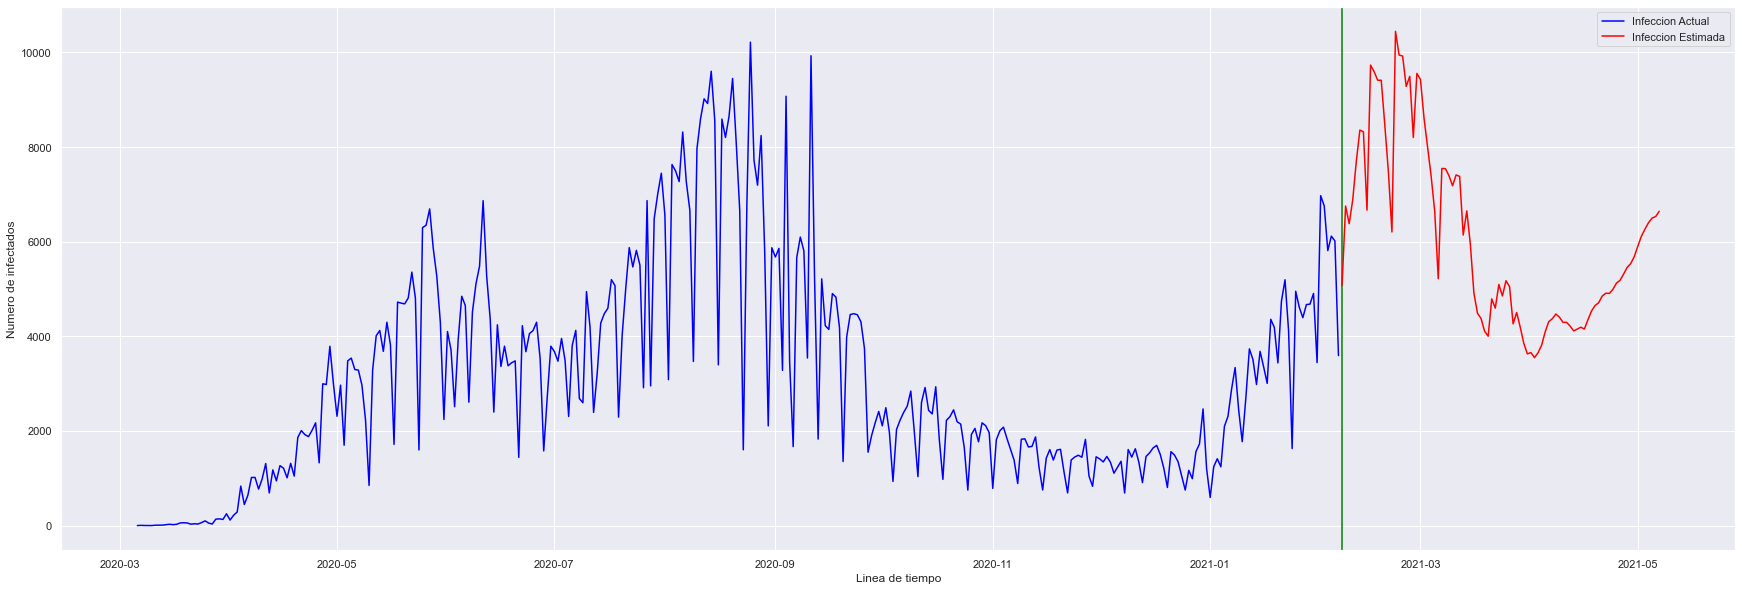

In [198]:
plot_prediccion_total(infected,results)


### CONCLUSIONES

#### Esta tarea de regresion usando redes neuronales busca estimar la curva de contagios de covid19 en el peru
#### Y se estima un crecimiento de la curva en un escenario que no cuente con vacunas hasta aproximadamente Mayo2021